In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from text import clean_text
from tqdm import tqdm_notebook

In [2]:
data = pd.read_csv('/home/vijjus/datasets/cdc_train.csv')

In [3]:
data.head()

,text,sex,age,event
0,57YOM WITH CONTUSION TO FACE AFTER STRIKING IT...,1,57,62
1,A 45YOM FELL ON ARM WHILE WORKING HAD SLIPPED ...,1,45,42
2,58YOM WITH CERVICAL STRAIN BACK PAIN S P REST...,1,58,26
3,33 YOM LAC TO HAND FROM A RAZOR KNIFE,1,33,60
4,53YOM AT WORK IN A WAREHOUSE DOING UNSPECIFIED...,1,53,71


In [4]:
data.text = pd.Series(clean_text(data.text))

In [5]:
data.head()

,text,sex,age,event
0,57 year old male with contusion to face after ...,1,57,62
1,a 45 year old male fell on arm while working h...,1,45,42
2,58 year old male with cervical strain back pai...,1,58,26
3,33 year old male laceration to hand from a raz...,1,33,60
4,53 year old male at work in a warehouse doing ...,1,53,71


In [6]:
data.to_csv("/home/vijjus/datasets/cdc_train_fixed.csv")

In [5]:
glove_path="/home/vijjus/glove/glove.6B.50d.txt"
embedding_size=50

In [6]:
# Load embedding matrix and vocab mappings
from vocab import get_glove
emb_matrix, word2id, id2word = get_glove(glove_path, embedding_size)

  2%|▏         | 9047/400000 [00:00<00:08, 43487.53it/s]

Loading GLoVE vectors from file: /home/vijjus/glove/glove.6B.50d.txt


100%|██████████| 400000/400000 [00:07<00:00, 51833.01it/s]


Text sanitization:

* Convert yom/yof/ym/yo/yf to "year old.."
* Split words that are joined

In [7]:
def do_split(token, output_list):
    if token not in word2id:
        split = -1
        for i in range(1,len(token)):
            if token[:i] in word2id:
                split = i
        if split is not -1:
            sub1 = token[:split]
            sub2 = token[split:]
            if sub1 in word2id:
                output_list.append(sub1)
            if sub2 in word2id:
                output_list.append(sub2)
    else:
        output_list.append(token)
    return output_list

In [8]:
# receive a list of tokens and return a transformed list that has tokens
# present in the embedding dictionary
def process_text(input_list):
    output_list = []
    for tok in input_list:
        output_list = do_split(tok, output_list)
    return output_list

In [9]:
# check for words that are not in the volabulary
def sanitize_data(data):
    total_len = len(data)
    for i in tqdm_notebook(range(total_len)):
        text = data.iloc[i]['text'].lower()
        tokens = text.split(" ")
        tokens = process_text(tokens)
        data.at[i, 'text'] = ' '.join(tokens)

In [10]:
sanitize_data(data)

In [13]:
# check for words that are not in the volabulary
def check_unks(data):
    unknowns = 0
    unknown_words = []
    total_len = len(data)
    for i in tqdm_notebook(range(total_len)):
        text = data.iloc[i]['text'].lower()
        tokens = text.split(" ")
        for j, token in enumerate(tokens):
            if token not in word2id and token not in unknown_words:
                unknown_words.append(token)
                unknowns += 1
    print("{} tokens not in embedding dictionary".format(unknowns))
    return unknown_words

In [14]:
unks = check_unks(data)


28 tokens not in embedding dictionary


In [15]:
unks

['eration',
 'emale',
 'ptoms',
 'ascial',
 'epidid',
 'emplo',
 'riend',
 'deplo',
 'erated',
 'acial',
 'nastics',
 'nasium',
 'ptomatic',
 'metry',
 'phadenopathy',
 'journe',
 'erating',
 'panum',
 'nastic',
 'parench',
 'enoptera',
 'ptons',
 'ully',
 'ectomy',
 'ront',
 'workp',
 'firep',
 'disp']

In [16]:
data.head()

,text,sex,age,event
0,57 year old male with contusion to face after ...,1,57,62
1,a 45 year old male fell on arm while working h...,1,45,42
2,58 year old male with cervical strain back pai...,1,58,26
3,33 year old male laceration to hand from a raz...,1,33,60
4,53 year old male at work in a warehouse doing ...,1,53,71


In [17]:
text = data['text']

In [18]:
ages = np.array(data['age'])

In [19]:
ages[:10]

array([57, 45, 58, 33, 53, 31, 54, 60, 36, 41])

In [20]:
injury_desc = []
for index, entry in data.iterrows():
    text = entry['text']
    injury_desc.append(text)

In [21]:
injury_desc[:10]

['57 year old male with contusion to face after striking it with a post pounder while setting a fence post',
 'a 45 year old male fell on arm while working had slipped on water fracture wrist',
 '58 year old male with cervical strain back pain status post restrained taxi driver in low speed rear end mvc no loss of consciousness no ab deployed',
 '33 year old male laceration to hand from a razor knife',
 '53 year old male at work in a warehouse doing unspecified lifting and strained lo wer back',
 '31 year old male at a clients home trimming a tree with a chain saw and the saw kicked back hit lower arm laceration to lower arm',
 '54 year old male ale cut finger sharpening a knife at work diagnosis right index finger laceration b',
 '60 year old male states he was working in a wood shop yesterday and felt something go into his right ear diagnosis foreign body removal right ear canal',
 '36 year old male complains of b left back pain since fri worse today patient lifts heavy trash bags at

In [22]:
injury_dlen = np.array([len(x) for x in injury_desc])

In [40]:
np.median(injury_dlen)

101.0

In [41]:
np.mean(injury_dlen)

104.1117656992907

In [23]:
np.argmax(injury_dlen)

126199

In [24]:
injury_dlen[27]

173

In [25]:
injury_desc[27]

'66 year old female employee preset ns after tripping over iv tubing in dark room and falling forward into the wall complains of face right knee pain diagnosis c h i trap spa'

(array([5.9900e+02, 1.1374e+04, 3.4040e+04, 3.9838e+04, 3.1659e+04,
        2.3568e+04, 1.1376e+04, 1.4070e+03, 8.9000e+01, 6.0000e+00]),
 array([ 19. ,  40.9,  62.8,  84.7, 106.6, 128.5, 150.4, 172.3, 194.2,
        216.1, 238. ]),
 <a list of 10 Patch objects>)

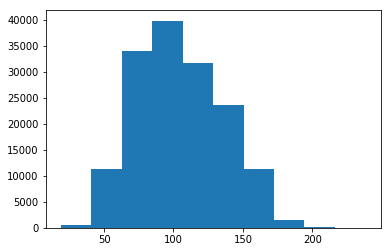

In [26]:
plt.hist(injury_dlen)

In [27]:
labels = np.array(data['event'])

In [28]:
events = sorted(set(labels))

(array([14429.,     0.,   381.,  4648.,  1234.,     0.,  1562., 22559.,
           52.,  4877., 11678., 42498.,  7362., 32085.,  8318.,   900.,
            0.,     0.,     0.,  1373.]),
 array([10.  , 14.45, 18.9 , 23.35, 27.8 , 32.25, 36.7 , 41.15, 45.6 ,
        50.05, 54.5 , 58.95, 63.4 , 67.85, 72.3 , 76.75, 81.2 , 85.65,
        90.1 , 94.55, 99.  ]),
 <a list of 20 Patch objects>)

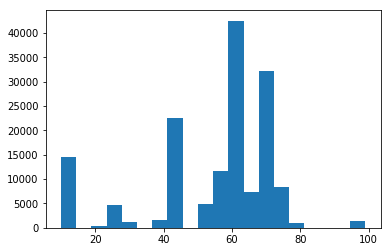

In [29]:
plt.hist(labels, bins=20)

Let's build vocabulary dictionaries for the words in the incident descriptions.

In [30]:
id2word = {}
word2id = {}
index = 0
for line in injury_desc:
    tokens = line.split(" ")
    for t in tokens:
        if t not in word2id:
            word2id[t] = index
            id2word[index] = t
            index += 1

In [31]:
len(id2word)

19742

In [32]:
incident_tokens = {}
for index, text in enumerate(injury_desc):
    incident = labels[index]
    if incident not in incident_tokens:
        incident_tokens[incident] = []
    tokens = text.split(" ")
    for t in tokens:
        if t not in incident_tokens[incident]:
            incident_tokens[incident].append(t)

In [33]:
incident_tokens[10]

['51',
 'year',
 'old',
 'male',
 'pain',
 'to',
 'left',
 '5th',
 'finger',
 'when',
 'responding',
 'a',
 'situation',
 'at',
 'work',
 'and',
 'broke',
 'out',
 'inri',
 'ng',
 'fracture',
 '30',
 'wrestling',
 'with',
 'another',
 'person',
 'weights',
 '300',
 'lb',
 'landed',
 'on',
 'hand',
 'all',
 'occured',
 'diagnosis',
 'sprain',
 'low',
 'back']

In [34]:
for ev in events:
    print("Words for event {}: {}".format(ev, len(incident_tokens[ev])))

Words for event 10: 38
Words for event 11: 4992
Words for event 12: 2630
Words for event 13: 3282
Words for event 20: 118
Words for event 21: 261
Words for event 22: 345
Words for event 23: 770
Words for event 24: 1564
Words for event 25: 494
Words for event 26: 2516
Words for event 27: 1777
Words for event 29: 14
Words for event 30: 26
Words for event 31: 1801
Words for event 32: 1123
Words for event 40: 314
Words for event 41: 1672
Words for event 42: 5709
Words for event 43: 3934
Words for event 44: 917
Words for event 45: 184
Words for event 49: 255
Words for event 50: 238
Words for event 51: 1386
Words for event 52: 1008
Words for event 53: 3509
Words for event 54: 127
Words for event 55: 7133
Words for event 56: 93
Words for event 59: 71
Words for event 60: 4039
Words for event 61: 321
Words for event 62: 8056
Words for event 63: 4880
Words for event 64: 3311
Words for event 65: 350
Words for event 66: 2384
Words for event 67: 410
Words for event 69: 585
Words for event 70: 3691


In [35]:
word_count_by_cat = {}
for word in id2word.values():
    word_count_by_cat[word] = 0
    for cat in events:
        if word in incident_tokens[cat]:
            word_count_by_cat[word] += 1

In [36]:
word_dist = [count for count in word_count_by_cat.values()]

(array([14884.,  2388.,   913.,   683.,   317.,   256.,   150.,    78.,
           52.,    21.]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ]),
 <a list of 10 Patch objects>)

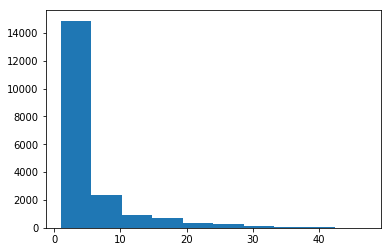

In [37]:
plt.hist(word_dist)

In [38]:
data.head()

,text,sex,age,event
0,57 year old male with contusion to face after ...,1,57,62
1,a 45 year old male fell on arm while working h...,1,45,42
2,58 year old male with cervical strain back pai...,1,58,26
3,33 year old male laceration to hand from a raz...,1,33,60
4,53 year old male at work in a warehouse doing ...,1,53,71
